<p style="background-color: #DCDCDC; font-family:calibri; font-size:40px; text-align:center; border-radius:50px 50px;">PREDICTING SOLAR ENERGY PRODUCTION</p>

# <p style="text-align:center; border-radius:50px 50px;">1. IMPORTING LIBRARIES</p>

In [13]:
import pingouin as pg
import datetime as dt
import numpy as np
import pandas as pd
import string
import re
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from fuzzywuzzy import fuzz, process
from spellchecker import SpellChecker
import scipy
import json
import itertools
from datetime import datetime
from scipy.stats import mode
from scipy.stats import chi2_contingency
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error

import ipywidgets as widgets
from IPython.display import display, HTML

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# <p style="text-align:center; border-radius:50px 50px;">2. DATA COLLECTION AND OVERVIEW</p>

In [16]:
df=pd.read_csv("Solar Energy.csv")

In [18]:
df.shape

(218115, 17)

In [20]:
df.head()

,Data Through Date,Project ID,Interconnection Date,Utility,City/Town,County,Zip,Division,Substation,Circuit ID,Developer,Metering Method,Estimated PV System Size (kWdc),PV System Size (kWac),Estimated Annual PV Energy Production (kWh),Energy Storage System Size (kWac),Number of Projects
0,12/31/2023,SDG-66301,12/29/2023,Con Ed,Richmond Hill,Queens,11418.0,CENY-BK,Brownsville_2,9B05,Kamtech Solar Solutions,NM,6.05,5.17,7100,NaN,1
1,12/31/2023,SDG-66299,12/29/2023,Con Ed,Bronx,Bronx,10473.0,CENY-BX,Parkchester_2,5X67,Kamtech Solar Solutions,NM,6.74,5.76,7911,NaN,1
2,12/31/2023,SDG-66288,12/29/2023,Con Ed,Brooklyn,Kings,11225.0,CENY-BK,Bensonhurst_2,4B08,SUNCO,NM,3.05,2.61,3585,NaN,1
3,12/31/2023,SDG-66284,12/29/2023,Con Ed,Brooklyn,Kings,11236.0,CENY-BK,Bensonhurst_2,3037,Kamtech Solar Solutions,NM,5.62,4.80,6592,NaN,1
4,12/31/2023,SDG-66277,12/28/2023,Con Ed,Springfield Gardens,Queens,11413.0,CENY-Q,Jamaica,9112,Kamtech Solar Solutions,NM,6.05,5.17,7100,NaN,1


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218115 entries, 0 to 218114
Data columns (total 17 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Data Through Date                            218115 non-null  object 
 1   Project ID                                   218112 non-null  object 
 2   Interconnection Date                         218115 non-null  object 
 3   Utility                                      218115 non-null  object 
 4   City/Town                                    218057 non-null  object 
 5   County                                       218115 non-null  object 
 6   Zip                                          218019 non-null  float64
 7   Division                                     132881 non-null  object 
 8   Substation                                   138171 non-null  object 
 9   Circuit ID                                   218085 non-nul

In [24]:
#columns_to_check = ['Utility', 'City/Town', 'County', 'Division', 'Substation', 'Developer', 'Metering Method']

columns_to_check = df.iloc[:, [3, 4, 5, 7, 8, 10, 11]]

# Create a dictionary to store unique values for each column
unique_values_dict = {}

# Loop through each categorical column and store unique values
for column in columns_to_check:
    unique_values_dict[column] = sorted(df[column].astype(str).unique())

# Convert the dictionary to a DataFrame
unique_values_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in unique_values_dict.items()]))

# Save the DataFrame to an Excel file
unique_values_df.to_excel('raw_unique_values.xlsx', index=False)

# <p style="text-align:center; border-radius:50px 50px;">3. DATA PREPROCESSING</p>

## 3.1 Treating Inconsistent Values

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

The dataset contains several inconsistent values that need to be addressed, including:
1. Mixed-case entries (both lowercase and uppercase).
2. Extra spaces.
3. Unnecessary punctuation.
4. Irrelevant suffixes.
5. Incorrect spellings.
6. Double duplicated values.

Addressing these issues can significantly enhance data quality and improve overall efficiency.

In [29]:
# Assuming df is your DataFrame and 'columns_to_check' is a list of categorical column names
columns_to_check = ['Utility', 'City/Town', 'County', 'Division', 'Substation', 'Developer', 'Metering Method']

# Function to check if a string is in the title case
def is_title_case(s):
    return s == s.title()

# Check for each column
for column in columns_to_check:
    inconsistent_values = df[~df[column].apply(lambda x: is_title_case(x) if isinstance(x, str) and pd.notna(x) else True)]
    if not inconsistent_values.empty:
        print(f"Inconsistent values found in column '{column}'.")
    else:
        print(f"All values in column '{column}' are in title case.")

Inconsistent values found in column 'Utility'.
Inconsistent values found in column 'City/Town'.
All values in column 'County' are in title case.
Inconsistent values found in column 'Division'.
Inconsistent values found in column 'Substation'.
Inconsistent values found in column 'Developer'.
Inconsistent values found in column 'Metering Method'.


In [31]:
# Apply title case transformation to the specified columns
df[columns_to_check] = df[columns_to_check].applymap(lambda x: x.title() if isinstance(x, str) and pd.notna(x) else x)

In [33]:
# Function to check if a string is in the title case
def is_title_case(s):
    return s == s.title()

# Check for each column
for column in columns_to_check:
    inconsistent_values = df[~df[column].apply(lambda x: is_title_case(x) if isinstance(x, str) and pd.notna(x) else True)]
    if not inconsistent_values.empty:
        print(f"Inconsistent values found in column '{column}'.")
    else:
        print(f"All values in column '{column}' are in title case.")

All values in column 'Utility' are in title case.
All values in column 'City/Town' are in title case.
All values in column 'County' are in title case.
All values in column 'Division' are in title case.
All values in column 'Substation' are in title case.
All values in column 'Developer' are in title case.
All values in column 'Metering Method' are in title case.


In [35]:
# Function to remove extra spaces
def remove_extra_spaces(text):
    # Normalize spaces
    return ' '.join(text.split())

# Apply the function to all categorical columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].apply(lambda x: remove_extra_spaces(x) if isinstance(x, str) else x)

In [37]:
# Function to remove punctuation from text
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# Identify categorical columns
date_columns = ['Data Through Date', 'Interconnection Date']
categorical_columns = df.select_dtypes(include=['object']).columns.drop(date_columns)

# Apply the remove_punctuation function to all categorical columns
df[categorical_columns] = df[categorical_columns].applymap(lambda x: remove_punctuation(x) if isinstance(x, str) else x)

In [39]:
# Function to remove all spaces
def remove_all_spaces(text):
    return text.replace(' ', '')

# Apply the function to all categorical columns
df['Division'] = df['Division'].apply(lambda x: remove_all_spaces(x) if isinstance(x, str) else x)

In [41]:
# Function to remove specific suffixes from the text
def remove_suffixes(text):
    # Define a regular expression pattern to match 'Inc', 'Corp', and 'LLC' with optional punctuation and case-insensitive
    pattern = r'\b(?:Co|Inc|Corp|Llc|Of N|Of Ny|Tek|New Yo|Led|Com|In|Ny|Ltd|Nrg|Usa|And Co|Op|L|C)\b\.?'
    return re.sub(pattern, '', text).strip()

# Apply the cleaning function to the 'Developer' column
df['Developer'] = df['Developer'].apply(lambda x: remove_suffixes(x) if isinstance(x, str) else x)

In [43]:
columns_to_check = ['City/Town', 'County', 'Division', 'Substation', 'Developer']

# Function to remove extra spaces and correct spelling mistakes
def clean_text(text):
    # Remove extra spaces
    text = ' '.join(text.split())
    # Convert text to string in case of float values
    text = str(text)
    # Regular expression to find and remove double names
    pattern = r'\b(\w+ \w+) \1\b'
    return re.sub(pattern, r'\1', text).strip()

for col in columns_to_check:
# Remove extra spaces and double names
    df[col] = df[col].apply(lambda x: clean_text(x) if isinstance(x, str) else x)

In [45]:
columns_to_check = ['City/Town', 'County', 'Division', 'Substation', 'Developer']

# Function to combine similar names
def combine_similar_names(names):
    names = [str(name) for name in names]  # Ensure all names are strings
    combined_names = []
    for name in names:
        split_name = name.split()
        matched = False
        for i, combined_name in enumerate(combined_names):
            split_combined_name = combined_name.split()
            # Check if the first word matches
            if split_name[0].lower() == split_combined_name[0].lower():
                # Check if the second word matches
                if len(split_name) > 1 and len(split_combined_name) > 1 and split_name[1].lower() == split_combined_name[1].lower():
                    # Check if the third word matches
                    if len(split_name) > 2 and len(split_combined_name) > 2 and split_name[2].lower() == split_combined_name[2].lower():
                        # Check if the fourth word matches
                        if len(split_name) > 3 and len(split_combined_name) > 3 and split_name[3].lower() == split_combined_name[3].lower():
                            combined_names[i] = combined_name if len(combined_name) > len(name) else name
                            matched = True
                            break
                elif len(split_name) == 3 or len(split_combined_name) == 3:
                    combined_names[i] = combined_name if len(combined_name) > len(name) else name
                    matched = True
                    break
        if not matched:
            combined_names.append(name)
    return combined_names

# Clean and combine names for all categorical columns
for col in columns_to_check:
    # Get unique values and combine similar names
    unique_values = df[col].unique()
    combined_values = combine_similar_names(unique_values)
    # Replace original column values with combined values
    df[col] = df[col].apply(lambda x: next((cv for cv in combined_values if str(x).lower() in cv.lower()), x))

In [47]:
columns_to_check = ['City/Town', 'County', 'Division', 'Substation', 'Developer']

# Function to find and replace similar values
def replace_similar_values(column, threshold=90):
    unique_values = column.unique()
    value_map = {}
    for value in unique_values:
        best_match = process.extractOne(value, unique_values, scorer=fuzz.token_sort_ratio)
        if best_match[1] >= threshold and value != best_match[0]:
            value_map[value] = best_match[0]
        else:
            value_map[value] = value
    return column.replace(value_map)

# Apply the function to all categorical columns
for col in columns_to_check:
    df[col] = replace_similar_values(df[col])

In [49]:
columns_to_check = df.iloc[:, [3, 4, 5, 7, 8, 10, 11]]

# Create a dictionary to store unique values for each column
unique_values_dict = {}

# Loop through each categorical column and store unique values
for column in columns_to_check:
    unique_values_dict[column] = sorted(df[column].astype(str).unique())

# Convert the dictionary to a DataFrame
unique_values = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in unique_values_dict.items()]))

# Save the DataFrame to an Excel file
unique_values.to_excel('unique_values.xlsx', index=False)

In [51]:
# Load the mapping dictionary from the JSON file
with open('map_dict_developer.json', 'r') as file:
    mapping_dict = json.load(file)

# Apply the mapping to the 'Developer' column
df['Developer'] = df['Developer'].replace(mapping_dict)

In [53]:
with open('map_dict_city.json', 'r') as file:
    mapping_dict = json.load(file)

# Apply the mapping to the 'Developer' column
df['City/Town'] = df['City/Town'].replace(mapping_dict)

In [55]:
# Load the abbreviation dictionary from the JSON file
with open('map_dict_abbreviation.json', 'r') as file:
    abbreviation_dict = json.load(file)

# Function to replace abbreviations
def replace_abbreviations(text):
    for abbr, full in abbreviation_dict.items():
        pattern = re.compile(r'\b' + re.escape(abbr) + r'\b')
        text = pattern.sub(full, text)
    return text

# Apply the function to the 'City/Town' column
df['City/Town'] = df['City/Town'].apply(replace_abbreviations)

# Display the cleaned DataFrame to verify changes
df.head()

,Data Through Date,Project ID,Interconnection Date,Utility,City/Town,County,Zip,Division,Substation,Circuit ID,Developer,Metering Method,Estimated PV System Size (kWdc),PV System Size (kWac),Estimated Annual PV Energy Production (kWh),Energy Storage System Size (kWac),Number of Projects
0,12/31/2023,SDG66301,12/29/2023,Con Ed,Richmond Hill,Queens,11418.0,CenyBk,Brownsville_2,9B05,Kamtech Solar Solutions,Nm,6.05,5.17,7100,NaN,1
1,12/31/2023,SDG66299,12/29/2023,Con Ed,Bronx,Bronx,10473.0,CenyBx,Parkchester_2,5X67,Kamtech Solar Solutions,Nm,6.74,5.76,7911,NaN,1
2,12/31/2023,SDG66288,12/29/2023,Con Ed,Brooklyn,Kings,11225.0,CenyBk,Bensonhurst_2,4B08,Sunco Project,Nm,3.05,2.61,3585,NaN,1
3,12/31/2023,SDG66284,12/29/2023,Con Ed,Brooklyn,Kings,11236.0,CenyBk,Bensonhurst_2,3037,Kamtech Solar Solutions,Nm,5.62,4.80,6592,NaN,1
4,12/31/2023,SDG66277,12/28/2023,Con Ed,Springfield Gardens,Queens,11413.0,CenyQ,Jamaica,9112,Kamtech Solar Solutions,Nm,6.05,5.17,7100,NaN,1


In [57]:
columns_to_check = df.iloc[:, [3, 4, 5, 7, 8, 10, 11]]

# Create a dictionary to store unique values for each column
unique_values_dict = {}

# Loop through each categorical column and store unique values
for column in columns_to_check:
    unique_values_dict[column] = sorted(df[column].astype(str).unique())

# Convert the dictionary to a DataFrame
unique_values_final = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in unique_values_dict.items()]))

# Save the DataFrame to an Excel file to recheck
unique_values_final.to_excel('unique_values_final.xlsx', index=False)

## 3.2 Type Conversion

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

Zip is currently listed as a float64. Zip codes are typically treated as categorical or string data (you never do calculations with it). So converting it to an object type might be more appropriate.

In [61]:
# Convert Zip to object type
df['Zip'] = df['Zip'].astype(str)

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">
    
To use 'Interconnection Date' feature for time-based analysis or feature engineering, converting it to a datetime format would be beneficial.

In [64]:
# Convert Interconnection Date to datetime
df['Interconnection Date'] = pd.to_datetime(df['Interconnection Date'])

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

Let us check the timeline of the data.

In [67]:
print('Interconnection Date :{} - {}'.format(df['Interconnection Date'].min(), df['Interconnection Date'].max()))

Interconnection Date :2000-12-21 00:00:00 - 2023-12-29 00:00:00


<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

The size of this particular dataset is very large. Large datasets require significant storage space, which can be expensive. And preprocessing large datasets can be time-consuming and resource-intensive. So, we will reduce the data size by considering 5 years of data, i.e., from 2019 to 2023.

In [70]:
# Count rows with dates before 2013 
data_before_2019 = df[df['Interconnection Date'] < '2019-01-01']
print(f"Number of rows before 2019: {len(data_before_2019)}")

Number of rows before 2019: 115569


In [72]:
# Drop data before 2013
df = df[df['Interconnection Date'] >= '2019-01-01']

# Verify the changes
print(f"Remaining data: {len(df)} rows")

Remaining data: 102546 rows


## 3.3 Missing Values Treatment

In [75]:
# Strip white spaces and replace empty strings with NaN
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df.replace('', np.nan, inplace=True)
df.replace('nan', np.nan, inplace=True)
df.replace('NaN', np.nan, inplace=True)

In [77]:
df.isna().sum()

Data Through Date                                  0
Project ID                                         0
Interconnection Date                               0
Utility                                            0
City/Town                                          0
County                                             0
Zip                                                8
Division                                       36933
Substation                                         0
Circuit ID                                        26
Developer                                          0
Metering Method                                  434
Estimated PV System Size (kWdc)                    0
PV System Size (kWac)                              0
Estimated Annual PV Energy Production (kWh)        0
Energy Storage System Size (kWac)              98659
Number of Projects                                 0
dtype: int64

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

Almost 36% of data is missing in the 'Division' feature and 96% of data is missing in the 'Energy Storage System Size (kWac)' feature. Treating the missing values in such columns using imputation methods may not be possible. Instead, we can delete the feature later in the feature removal step.

The Circuit ID feature is unlikely to contribute to the prediction, so we will also remove it later. Then, we will use the mode imputation for the remaining feature 'Metering Method'. 

In [80]:
# Using mode imputation for the 'Metering Method' feature
mode_column1 = df['Metering Method'].mode()[0]
df['Metering Method'].fillna(mode_column1, inplace=True)

mode_column2 = df['Zip'].mode()[0]
df['Zip'].fillna(mode_column2, inplace=True)

## 3.4 Irrelevant Feature Removal

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

* Data Through Date: The data for all projects is current up to December 31, 2023. Since all the values in this feature are the same they don't provide any additional information. 
* Project ID: This is just an identifier and is unlikely to have predictive power.
* Division: This may be redundant if city and county information is already included. (High missing data)
* Circuit ID: Similar to Project ID, it is unlikely to contribute to the prediction.
* Energy Storage System Size (kWac): If the dataset has few projects with energy storage, this feature might not be very informative. (High missing data)
* Number of Projects: Here each row in the dataset represents a single solar power project so it doesn't provide any variability.

Therefore, we can drop these columns.

In [84]:
df.drop(['Data Through Date', 'Project ID', 'Division', 'Circuit ID', 'Energy Storage System Size (kWac)', 'Number of Projects'], axis=1, inplace=True)

In [86]:
df.isna().sum()

Interconnection Date                           0
Utility                                        0
City/Town                                      0
County                                         0
Zip                                            0
Substation                                     0
Developer                                      0
Metering Method                                0
Estimated PV System Size (kWdc)                0
PV System Size (kWac)                          0
Estimated Annual PV Energy Production (kWh)    0
dtype: int64

## 3.5 Duplicate Treatment

In [89]:
# Checking for duplicate values
duplicates = df[df.duplicated(keep='first')]
print(duplicates.shape)
duplicates.head()

(1088, 11)


,Interconnection Date,Utility,City/Town,County,Zip,Substation,Developer,Metering Method,Estimated PV System Size (kWdc),PV System Size (kWac),Estimated Annual PV Energy Production (kWh)
20,2023-12-28,Con Ed,Jamaica,Queens,11432.0,Jamaica,Sunco Project,Nm,6.45,5.51,7567
53,2023-12-15,Con Ed,Ridgewood,Queens,11385.0,Glendale,Sunco Project,Nm,2.38,2.03,2788
179,2023-12-27,Con Ed,Brooklyn,Kings,11234.0,Bensonhurst_2,Momentum Solar,Nm,2.04,1.74,2390
271,2023-12-27,Con Ed,Glen Oaks,Queens,11004.0,Jamaica,Momentum Solar,Nm,3.39,2.90,3983
332,2023-12-07,Con Ed,Springfield Gardens,Queens,11413.0,Jamaica,Sunrun Installation Services,Nm,7.02,6.00,8240


In [91]:
# Dropping the duplicate columns
df.drop_duplicates(inplace=True)

In [93]:
df.head()

,Interconnection Date,Utility,City/Town,County,Zip,Substation,Developer,Metering Method,Estimated PV System Size (kWdc),PV System Size (kWac),Estimated Annual PV Energy Production (kWh)
0,2023-12-29,Con Ed,Richmond Hill,Queens,11418.0,Brownsville_2,Kamtech Solar Solutions,Nm,6.05,5.17,7100
1,2023-12-29,Con Ed,Bronx,Bronx,10473.0,Parkchester_2,Kamtech Solar Solutions,Nm,6.74,5.76,7911
2,2023-12-29,Con Ed,Brooklyn,Kings,11225.0,Bensonhurst_2,Sunco Project,Nm,3.05,2.61,3585
3,2023-12-29,Con Ed,Brooklyn,Kings,11236.0,Bensonhurst_2,Kamtech Solar Solutions,Nm,5.62,4.80,6592
4,2023-12-28,Con Ed,Springfield Gardens,Queens,11413.0,Jamaica,Kamtech Solar Solutions,Nm,6.05,5.17,7100


In [95]:
df.shape

(101458, 11)

## 3.6 Outlier Treatment

In [98]:
categorical_columns = df.iloc[:, [1, 2, 3, 5, 6, 7]]
numerical_columns = df.iloc[:, [8, 9, 10]]

### 3.6.1 Checking and printing the outliers in the numerical columns

In [101]:
for column in numerical_columns:
  print(f"Value counts for {column}:")
  freq = df[column].value_counts(normalize=False)
  print(freq)

Value counts for Estimated PV System Size (kWdc):
Estimated PV System Size (kWdc)
7.02      6401
8.89      6156
4.45      4811
11.70     3708
5.85      3216
          ... 
17.63        1
12.76        1
318.68       1
29.09        1
386.75       1
Name: count, Length: 2090, dtype: int64
Value counts for PV System Size (kWac):
PV System Size (kWac)
6.00      6401
7.60      6156
3.80      4811
10.00     3708
5.00      3216
          ... 
16.62        1
6.55         1
13.78        1
3.64         1
325.00       1
Name: count, Length: 2019, dtype: int64
Value counts for Estimated Annual PV Energy Production (kWh):
Estimated Annual PV Energy Production (kWh)
8240      6401
10438     6154
5219      4811
13734     3708
6867      3214
          ... 
13446        1
12374        1
8254         1
24570        1
453983       1
Name: count, Length: 2415, dtype: int64


#### Box Plot

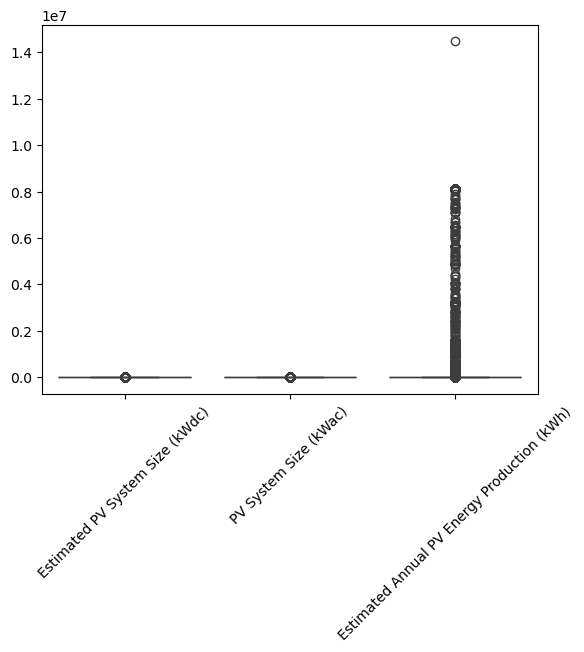

In [104]:
sns.boxplot(data=numerical_columns)
plt.xticks(rotation=45)
plt.show()

In [106]:
# Checking for the skewness
scipy.stats.skew(df.iloc[:, [8, 9, 10]], axis = 0, bias = True)

array([17.29381405, 17.25411394, 17.29381363])

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

The data (numerical features) have many outliers and are also highly skewed (positive). Winsorization is generally preferred for handling outliers in highly skewed datasets because it retains more information and reduces the impact of extreme values without completely discarding them.

#### Winsorization

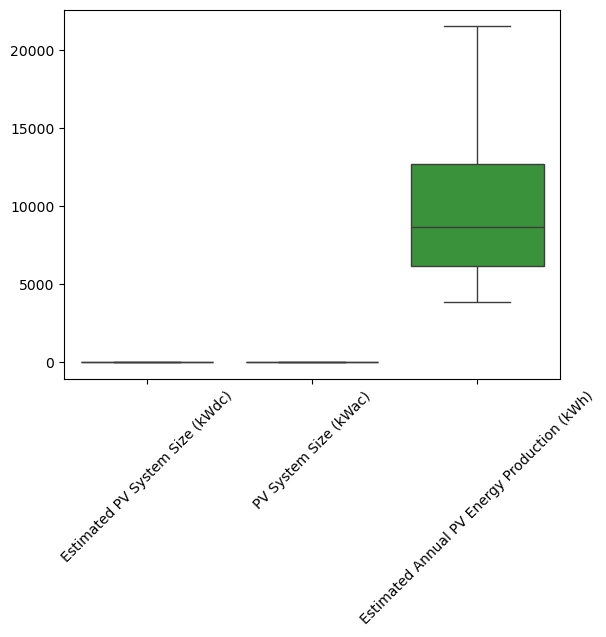

In [110]:
for column in numerical_columns:
# Define the percentile limits (e.g., 5% and 95%)
    lower_percentile = np.percentile(df[column], 5)
    upper_percentile = np.percentile(df[column], 95)

    # Winsorize the outliers
    df[column] = np.where(df[column] < lower_percentile, lower_percentile, df[column])
    df[column] = np.where(df[column] > upper_percentile, upper_percentile, df[column])

# Plot the boxplot with outliers removed
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.show()

In [112]:
def detect_outliers_iqr(df, column):
    """Detects outliers in a column using the IQR method.

    Args:
        df: The DataFrame containing the data.
        column: The name of the column to check for outliers.

    Returns:
        A list of outliers in the given column.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)].tolist()
    return outliers

# Finding and printing outliers for each numeric column
for column in df.select_dtypes(include='number').columns:
    outliers = detect_outliers_iqr(df, column)
    print(f"Outliers in {column}: {outliers}")

Outliers in Estimated PV System Size (kWdc): []
Outliers in PV System Size (kWac): []
Outliers in Estimated Annual PV Energy Production (kWh): []


In [114]:
df.shape

(101458, 11)

### 3.6.2 Checking and printing the outliers in the categorical columns

In [117]:
for column in categorical_columns:
  print(f"Value counts for {column}:")
  freq = df[column].value_counts(normalize=False)
  outliers = freq[freq < 0.01 * len(df)]
  print(freq)
  print(f"Possible Outliers in {outliers}: \n")

Value counts for Utility:
Utility
Con Ed            40393
Psegli            36606
National Grid      6972
Central Hudson     6645
OR                 5228
Nyseg              4252
Rge                1362
Name: count, dtype: int64
Possible Outliers in Series([], Name: count, dtype: int64): 

Value counts for City/Town:
City/Town
Brooklyn          8734
Staten Island     5991
Bronx             4510
Jamaica           2941
Queens Village    1214
                  ... 
Canisteo             1
North Java           1
Randall              1
Pine Hill            1
Tusten               1
Name: count, Length: 1428, dtype: int64
Possible Outliers in City/Town
Saint Albans    983
Poughkeepsie    815
Levittown       772
Baldwin         752
Massapequa      751
               ... 
Canisteo          1
North Java        1
Randall           1
Pine Hill         1
Tusten            1
Name: count, Length: 1420, dtype: int64: 

Value counts for County:
County
Suffolk        19697
Nassau         16155
Queens     

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

Categorical data doesn't inherently have the concept of outliers. However, we can identify and handle unusual or unexpected categories that might skew our analysis. Here, we can observe that there are a few categories with fewer values, which can be considered outliers but are potential data points. So, we will leave these data values as it is, as removing or grouping them can change the whole distribution and may lead to data loss.

# <p style="text-align:center; border-radius:50px 50px;">4. EDA</p>

## 4.1 Summary Statistics 

### 4.1.1 Summary Statistics for Numerical Variables

In [123]:
df.describe()

,Interconnection Date,Estimated PV System Size (kWdc),PV System Size (kWac),Estimated Annual PV Energy Production (kWh)
count,101458,101458.000000,101458.000000,101458.000000
mean,2021-11-07 09:32:11.605196288,8.418747,7.195284,9881.883676
min,2019-01-01 00:00:00,3.280000,2.800000,3845.000000
25%,2020-09-17 00:00:00,5.240000,4.480000,6153.000000
50%,2022-02-03 00:00:00,7.370000,6.300000,8652.000000
75%,2023-02-17 00:00:00,10.820000,9.250000,12704.000000
max,2023-12-29 00:00:00,18.320000,15.660000,21507.000000
std,NaN,4.082588,3.490024,4793.162247


<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

### Inferences:
**Interconnection Date:**
The interconnection dates range from January 1, 2019, to December 29, 2023. Half of the systems were interconnected before February 3, 2022 and half after. Majority of systems were interconnected between the dates September 17, 2020 and February 17, 2023, suggesting recent installations.

**Estimated PV System Size (kWdc):**
The average estimated PV system size is approximately 8.42 kWdc. The system sizes range from 3.28 kWdc to 18.32 kWdc. The IQR is from 5.24 kWdc to 10.82 kWdc, indicating that 50% of the systems fall within this range. And the standard deviation is 4.082588, showing some variability in system sizes, which is quite normal in practice.

**PV System Size (kWac):**
The average PV system size is approximately 7.19 kWac. The system sizes range from 2.8 kWac to 15.66 kWac. The IQR is from 4.48 kWac to 9.25 kWac. And the standard deviation is 3.490024, indicating variability in system sizes, slightly less than that of the kWdc values.

**Estimated Annual PV Energy Production (kWh):**
The average estimated annual energy production is approximately 9881.88 kWh. The energy production ranges from 3845.0 kWh to 21507.0 kWh. Half of the systems produce 6153.0 kWh to 12704.0 kWh energy anually. The standard deviation is 4793.162247, indicating significant variability in energy production, which aligns with the variability in system sizes.

**General Observations:**
* Consistency: The statistics suggest a consistent and reliable dataset with typical variations in system sizes and energy production.
* Recent Installations: The dates show a trend towards more recent installations, which might reflect the growing adoption of solar energy.
* Proportionality: The proportional relationship between kWdc and kWac sizes and their respective energy outputs reinforces the predictability and efficiency of the systems.

### 4.1.2 Summary Statistics for Categorical Variables

In [127]:
df.describe(include='object').T

,count,unique,top,freq
Utility,101458,7,Con Ed,40393
City/Town,101458,1428,Brooklyn,8734
County,101458,62,Suffolk,19697
Zip,101458,1567,11236.0,1322
Substation,101458,1780,Buchanan,37422
Developer,101458,905,Sunrun Installation Services,14987
Metering Method,101458,6,Nm,100057


<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

### Inferences:
1. The "Con Ed" utility company stands out among the seven utility companies in the dataset, dominating with a substantial share of the entries. This indicates that a significant number of solar projects are interconnected with Con Ed, highlighting its pivotal role in the region's solar energy landscape.
2. Brooklyn appears to be a major hub for solar projects, given that it has the highest number of entries compared to other cities or towns. The dataset covers a wide range of locations with a total of 1,428 unique cities/towns.
3. Suffolk County is the leading county in terms of the number of solar projects, indicating a high concentration of 19697 solar installations in this area.
4. The ZIP code 11236 has the highest number of solar projects, which can provide insights into local demand and adoption of solar energy within this specific area.
5. Buchanan substation has 37422 number of installations, which is the highest, suggesting a significant concentration in this area.
6. "Sunrun" is the most common developer in the dataset, suggesting that this developer has a significant market presence or a substantial number of installations in the area.
7. The majority of the projects use the "Net Metering" method, indicating that this is the preferred or standard metering approach for solar projects in the dataset.

## 4.2 Univariate Analysis

In [131]:
categorical_columns = df.iloc[:, [1, 2, 3, 5, 6, 7]]
numerical_columns = df.iloc[:, [8, 9, 10]]

### 4.2.1 Numerical Variables Univariate Analysis

#### Histogram KDE PLot

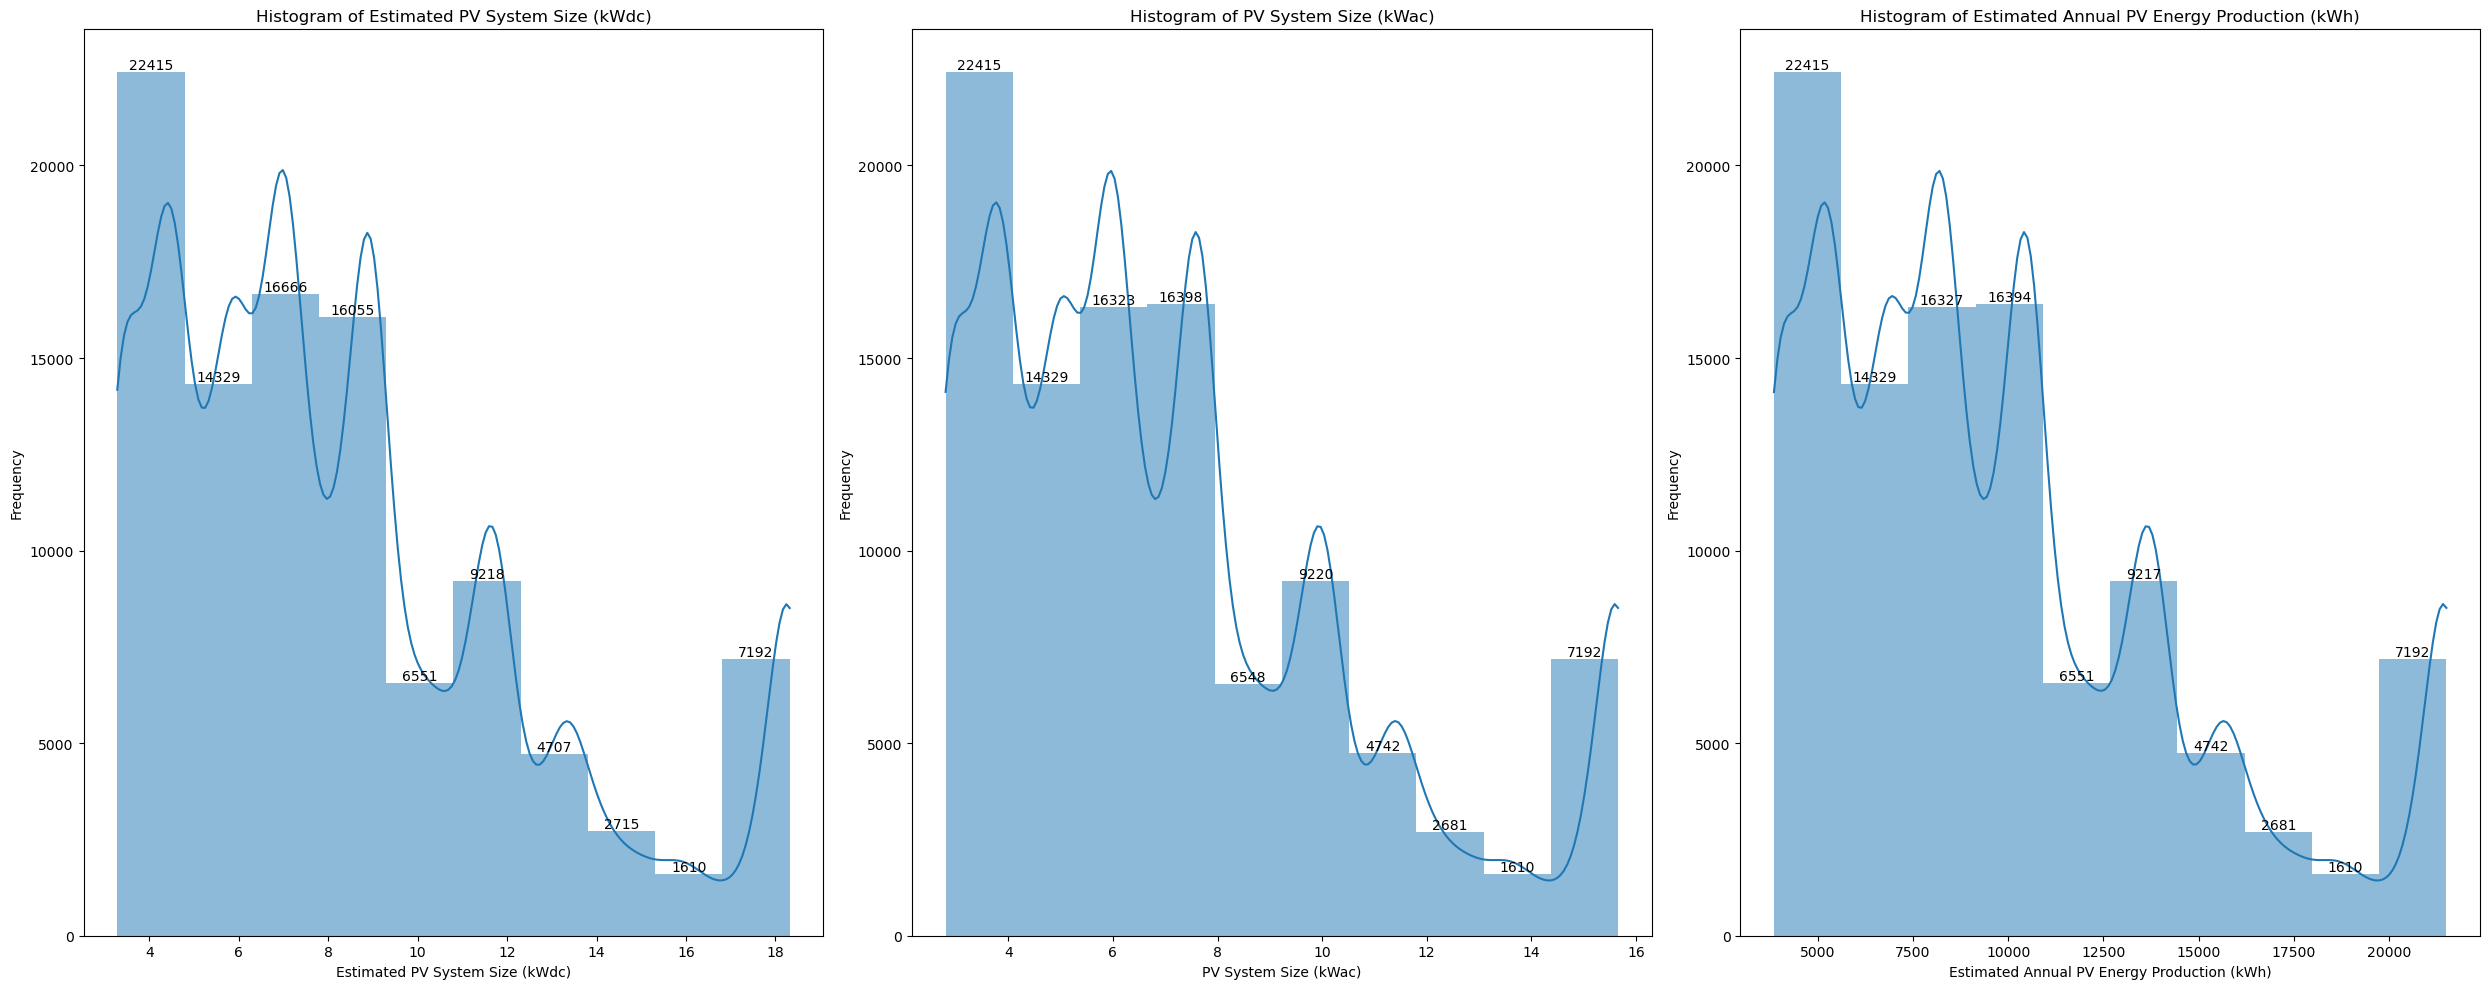

In [135]:
fig, axes = plt.subplots(1, 3, figsize=(25, 10))

# Flattening the axes array for easier iteration
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    sns.histplot(numerical_columns[column], bins=10, kde=True, edgecolor='none', ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

    # Adding count labels on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height())}', 
                         (p.get_x() + p.get_width() / 2, p.get_height()), 
                         ha='center', va='bottom')
        
plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

### Inferences:

**1. Histogram of Estimated PV System Size (kWdc):**
* Distribution: The most frequent estimated PV system size is around 4 kWdc, with a peak frequency of 22,415. Other common sizes are 7 kWdc (16,666), 9 kWdc (16,055), and 11 kWdc (9,218) approximately.
* Trend: There's a noticeable decline in frequency as the system size increases beyond 9 kWdc. This suggests that smaller PV systems are more common, potentially due to residential installations being more prevalent than larger commercial ones.

**2. Histogram of PV System Size (kWac):**
* Distribution: Similarly, the most frequent PV system size is around 4 kWac, with a peak frequency of 22,415. Other frequent sizes include 6 kWac (16,323), 8 kWac (16,398), and 10 kWac (9,220).
* Correlation: The pattern closely mirrors that of the estimated PV system size (kWdc), indicating a strong correlation between the estimated and actual PV system sizes, reinforcing the reliability of the estimates.
* Standard Sizes: The clustering around specific sizes (4 kWac, 6 kWac, 8 kWac) suggests standard system sizes are common, likely due to typical residential system configurations.

**3. Histogram of Estimated Annual PV Energy Production (kWh):**
* Distribution: The most frequent estimated annual energy production is around 5,000 kWh, with a peak frequency of 22,415. Other notable production values include 8,000 kWh (16,327), 10,500 kWh (16,394), and 13,500 kWh (9,217) approximately.
* Energy Production: The distribution suggests that many installations produce energy within these common ranges, which might correspond to the typical annual electricity consumption for residential properties.
* Efficiency: The strong correlation between system size and energy production is evident, as similar system sizes yield proportional energy production, indicating efficient systems.

**General Observations:**
* Residential Focus: The prevalence of smaller system sizes and corresponding energy production values suggests a significant focus on residential installations.
* Consistency: The close alignment between estimated and actual system sizes (kWdc vs. kWac) and their corresponding energy production implies consistent and reliable estimation methods.
* Energy Needs: The estimated energy production values reflect the typical energy needs of residential properties, providing insights into common usage patterns.

### 4.2.2 Categorical Variables Univariate Analysis

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

'City/Town', 'County', 'Zip', 'Substation', and 'Developer' exhibit a high number of distinct values, with counts of 1,428, 62, 1,567, 1,780, and 905 respectively. This abundance of unique entries makes it difficult to visualize these features effectively using a count plot. Instead, we will focus on analyzing the distributions of the 'Utility' and 'Metering Method' variables. Following that, we will identify and examine the top 30 most common values in the 'City/Town', 'County', 'Zip', 'Substation', and 'Developer' columns.

#### Count Plot

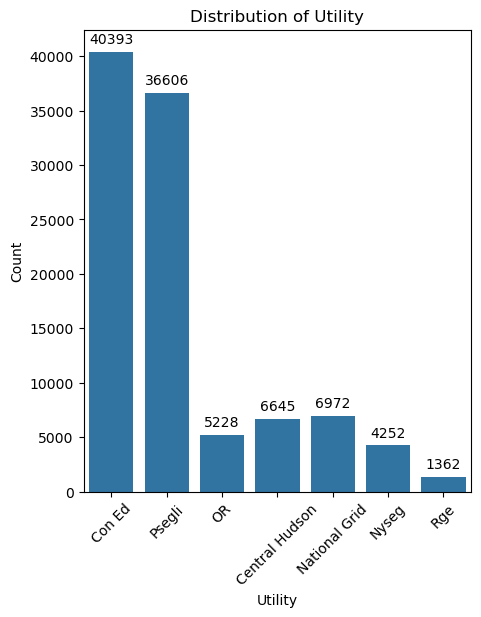

In [141]:
plt.figure(figsize=(5, 6)) 
plot = sns.countplot(data=df, x='Utility', edgecolor='none') 

# Adding title and labels 
plt.title('Distribution of Utility') 
plt.xlabel('Utility') 
plt.ylabel('Count') 
plt.xticks(rotation=45) 

# Adding the annotations 
for p in plot.patches: plot.annotate(format(p.get_height(), '.0f'), 
                                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                                     ha = 'center', va = 'center', 
                                     xytext = (0, 9), 
                                     textcoords = 'offset points') 
# Displaying the plot 
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

### Inferences:
1. Con Ed is the most prominent utility company in the dataset, with a total count of 40,393. This suggests that a significant number of solar projects are connected to Con Ed's grid.
2. PSEGLI follows closely behind Con Ed with 36,606 entries.
3. NYSEG (4,252) and RGE (1,362) have the lowest counts, showing they are less involved or have fewer solar projects connected to their grids.

**General Observations:**
* Market Share: The dominance of Con Ed and PSEGLI suggests they have a large market share in the region, potentially offering more support or incentives for solar energy projects.
* Regional Focus: The concentration of projects with Con Ed and PSEGLI could point to specific regions where solar adoption is higher, perhaps due to better infrastructure or policies.
* Opportunity for Growth: Utilities with lower counts may have opportunities to expand their solar energy initiatives, leveraging the experience of more prominent utilities.
* Disparity in Counts: There is a significant disparity between the top utilities (Con Ed and PSEGLI) and the others. This could imply regional variations in solar adoption, different levels of market penetration by the utilities, or possibly varying regulatory environments.

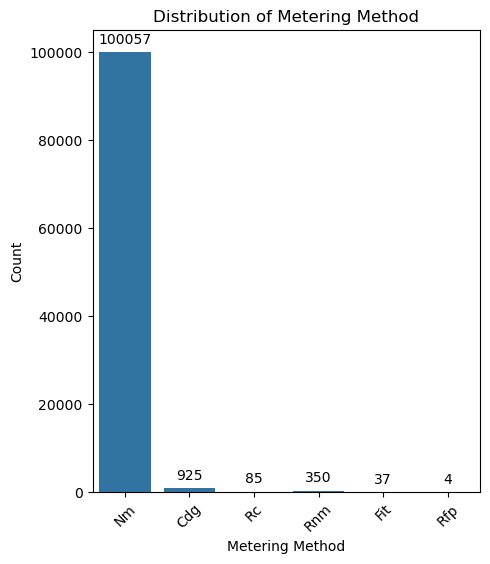

In [144]:
plt.figure(figsize=(5, 6)) 
plot = sns.countplot(data=df, x='Metering Method', edgecolor='none') 

# Adding title and labels 
plt.title('Distribution of Metering Method') 
plt.xlabel('Metering Method') 
plt.ylabel('Count') 
plt.xticks(rotation=45) 

# Adding the annotations 
for p in plot.patches: plot.annotate(format(p.get_height(), '.0f'), 
                                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                                     ha = 'center', va = 'center', 
                                     xytext = (0, 9), 
                                     textcoords = 'offset points') 
# Displaying the plot 
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

### Inferences:

**1. Dominance of Nm Method:**
* The Nm (Net Metering) method is overwhelmingly the most common, with 100,057 counts. This suggests that net metering is the standard or preferred method for measuring solar energy production in the dataset.
* The dominance of this method could be due to favorable policies, ease of implementation, or widespread adoption by utility companies.

**2. Relative Rarity of Other Methods:**
* Cdg (Community Distributed Generation) follows with 925 counts, indicating some level of adoption but significantly less compared to net metering.
* Rc (Remote Crediting) and Rmn (Remote Net Metering) have 85 and 350 counts, respectively. These methods are less common, possibly due to specific eligibility criteria or limited implementation.
* Fit (Feed-in Tariff) and Rfp (Renewable Feed-in Tariff) are the least common, with only 37 and 4 counts, respectively. The low adoption rates could be attributed to limited policy support or niche applicability.

**3. Policy and Market Influence:**
* The distribution of metering methods reflects the influence of energy policies and market preferences. Methods with strong policy backing or economic benefits (like Nm) tend to have higher adoption rates.
* The disparity in counts suggests that some metering methods might have higher entry barriers or less attractive incentives compared to others.

**4. Implications for Future Projects:**
* For new solar projects, understanding the popularity and distribution of different metering methods can help in selecting the most viable and beneficial option.
* Policymakers and utility companies can analyze this distribution to identify gaps and potential areas for encouraging the adoption of less common metering methods.

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

**Metering Method:<br>**
Since 98% of the systems use the net metering method (Nm), this feature might not add much value in distinguishing between different geographical areas in your clustering analysis. The dominance of one metering method can overshadow the variations brought by other methods, making it less useful for meaningful clustering.<br>

So, we will filter the data to include only systems using the Nm method. Once filtered, the metering method column becomes redundant and can be dropped.<br>

**Utility:<br>**
The market is dominated by the Con Ed and Psegli utilities. However, other utilities are also utilized extensively. We will require additional analysis to verify whether they have a good association with energy production.

In [148]:
# Filtering the data to include only systems with the net metering method (Nm) 
data = df[df['Metering Method'] == 'Nm']

In [150]:
# Dropping the 'Metering Method' column as it becomes redundant
data.drop(columns=['Metering Method'], inplace=True)

In [152]:
data.shape

(100057, 10)

In [154]:
selected_columns = ['City/Town', 'County', 'Zip', 'Substation', 'Developer']
data_selected = data[selected_columns] 

top_30_values = {}

for col in selected_columns:
    top_30 = data_selected[col].value_counts().head(30)
    top_30_values[col] = top_30.index.tolist()  # Storing the top 30 values as a list

# Create a DataFrame to store the top 30 values for each column
top_30_df = pd.DataFrame(top_30_values)
top_30_df

# Optionally, you can also save this DataFrame to a file:
#top_30_df.to_csv("top_30_values.csv", index=False)

,City/Town,County,Zip,Substation,Developer
0,Brooklyn,Suffolk,11236.0,Buchanan,Sunrun Installation Services
1,Staten Island,Nassau,11434.0,Jamaica,Momentum Solar
2,Bronx,Queens,10314.0,Brownsville_2,Trinity Solar Systems
3,Jamaica,Kings,11413.0,Bensonhurst_2,Sunation Solar Systems
4,Queens Village,Westchester,11412.0,Parkchester_2,Sunpower By Venture Solar
5,Springfield Gardens,Richmond,11234.0,Corona_1,New York State Solar Farm
6,Valley Stream,Bronx,11758.0,Fresh_Kills,Long Island Power Solutions
7,Yonkers,Orange,10312.0,Brownsville_1,Kamtech Solar Solutions
8,Saint Albans,Dutchess,10469.0,Bensonhurst_1,Ben Drexel Empire Solar Solutions
9,Poughkeepsie,Rockland,10466.0,Fox_Hills,Sunco Project


## 4.3 Bivariate Analysis

### 4.3.1 Numerical vs Target Bivariate Analysis

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

Numerical vs Target Bivariate Analysis will be directly acquired from the Numerical vs Numerical Bivariate Analysis using scatter plots, which shows that both PV System Size and Estimated PV System Size have a strong impact on the Estimated Annual PV Energy Production.

### 4.3.2 Numerical vs Numerical Bivariate Analysis

#### Scatter Plot

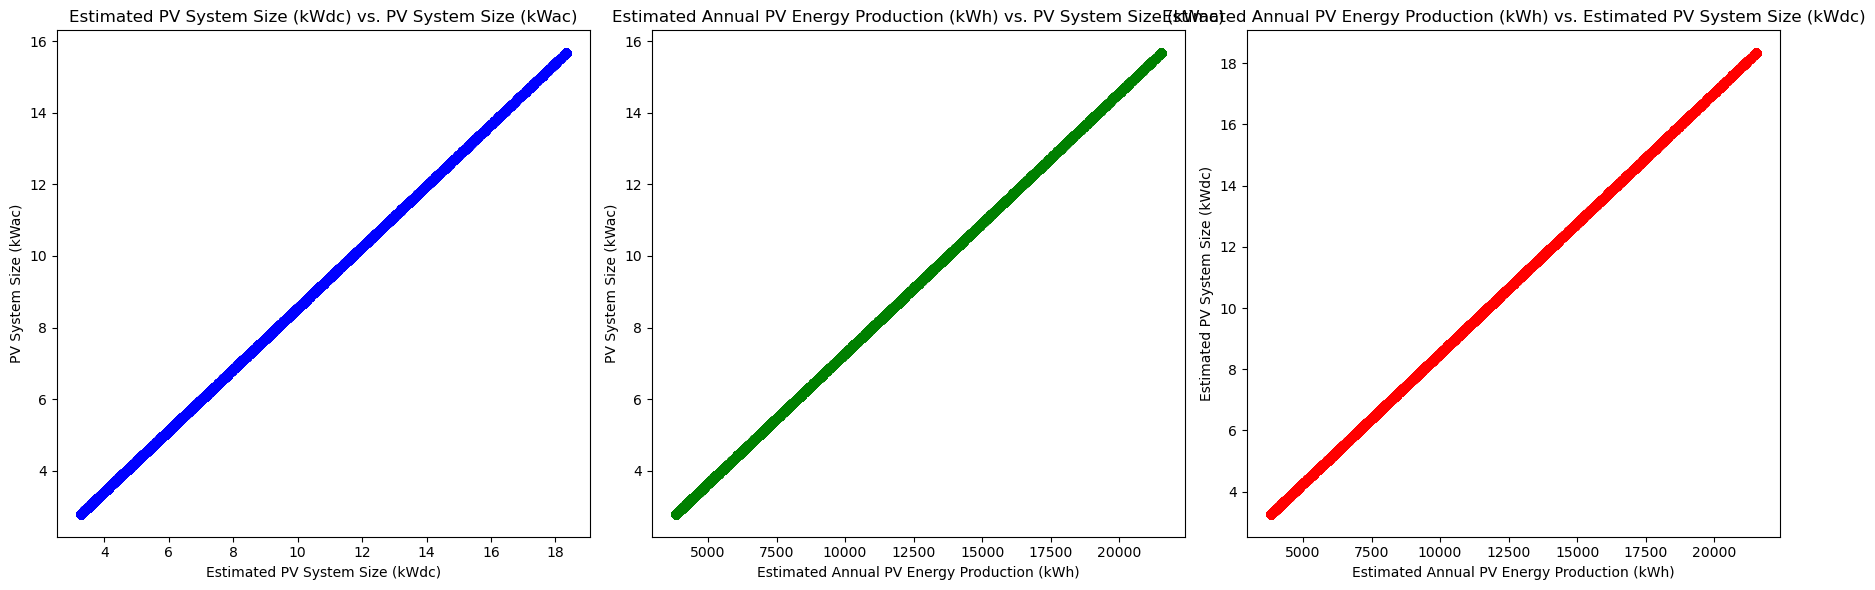

In [157]:
# Creating the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot 1: Estimated PV System Size (kWdc) vs. PV System Size (kWac)
axes[0].scatter(data['Estimated PV System Size (kWdc)'], data['PV System Size (kWac)'], color='blue', alpha=0.6)
axes[0].set_title('Estimated PV System Size (kWdc) vs. PV System Size (kWac)')
axes[0].set_xlabel('Estimated PV System Size (kWdc)')
axes[0].set_ylabel('PV System Size (kWac)')

# Scatter plot 2: Estimated Annual PV Energy Production (kWh) vs. PV System Size (kWac)
axes[1].scatter(data['Estimated Annual PV Energy Production (kWh)'], data['PV System Size (kWac)'], color='green', alpha=0.6)
axes[1].set_title('Estimated Annual PV Energy Production (kWh) vs. PV System Size (kWac)')
axes[1].set_xlabel('Estimated Annual PV Energy Production (kWh)')
axes[1].set_ylabel('PV System Size (kWac)')

# Scatter plot 3: Estimated Annual PV Energy Production (kWh) vs. Estimated PV System Size (kWdc)
axes[2].scatter(data['Estimated Annual PV Energy Production (kWh)'], data['Estimated PV System Size (kWdc)'], color='red', alpha=0.6)
axes[2].set_title('Estimated Annual PV Energy Production (kWh) vs. Estimated PV System Size (kWdc)')
axes[2].set_xlabel('Estimated Annual PV Energy Production (kWh)')
axes[2].set_ylabel('Estimated PV System Size (kWdc)')

# Adjust layout
plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

**Estimated PV System Size (kWdc) vs. PV System Size (kWac):<br>**
The data points form a nearly perfect straight line, indicating that the estimated PV system size is a very accurate predictor of the actual PV system size. This implies that the estimation methods used are reliable.<br>

**Estimated Annual PV Energy Production (kWh) vs. PV System Size (kWac):<br>**
There is a clear positive linear relationship between the PV system size (kWac) and the estimated annual PV energy production (kWh). As the size of the PV system increases, the estimated annual energy production also increases. The strong linear pattern indicates that the PV system size (kWac) can be a good predictor of annual energy production (kWh).<br>

**Estimated Annual PV Energy Production (kWh) vs. Estimated PV System Size (kWdc):<br>**
The relationship indicates that scaling up the PV System Size will lead to a proportional increase in energy production, which is useful for planning and optimizing larger solar projects and installations. Knowing that larger systems produce proportionally more energy can help in making cost-effective decisions about system sizing for desired energy outputs.<br>

**Difference from the Plot of 'Estimated Annual PV Energy Production (kWh) vs. PV System Size (kWac)' and 'Estimated Annual PV Energy Production (kWh) vs. Estimated PV System Size (kWdc)':**

* Measurement Basis: The current scatter plot uses Estimated PV System Size (kWdc), which represents the direct current capacity of the PV system. In contrast, the other plot uses PV System Size (kWac), representing the alternating current capacity after accounting for conversion losses.

* Conversion Efficiency: The kWac values are typically lower than kWdc values due to losses in converting from DC to AC. Therefore, the slope of the relationship in the plot with kWac might be slightly different, reflecting these efficiency losses.

* Data Range: The actual numeric range of kWdc and kWac values might differ, affecting the visual spread of the data points in the scatter plot.

These distinctions are significant when interpreting the plots for different applications in solar energy projects, emphasizing different stages of energy conversion and system capacity.

### 4.3.3 Categorical vs Target Bivariate Analysis

In [161]:
data.rename(columns={'Estimated Annual PV Energy Production (kWh)': 'Energy_Production_kWh',
                    'City/Town': 'City_Town'}, inplace=True)

In [163]:
data.head()

,Interconnection Date,Utility,City_Town,County,Zip,Substation,Developer,Estimated PV System Size (kWdc),PV System Size (kWac),Energy_Production_kWh
0,2023-12-29,Con Ed,Richmond Hill,Queens,11418.0,Brownsville_2,Kamtech Solar Solutions,6.05,5.17,7100.0
1,2023-12-29,Con Ed,Bronx,Bronx,10473.0,Parkchester_2,Kamtech Solar Solutions,6.74,5.76,7911.0
2,2023-12-29,Con Ed,Brooklyn,Kings,11225.0,Bensonhurst_2,Sunco Project,3.28,2.80,3845.0
3,2023-12-29,Con Ed,Brooklyn,Kings,11236.0,Bensonhurst_2,Kamtech Solar Solutions,5.62,4.80,6592.0
4,2023-12-28,Con Ed,Springfield Gardens,Queens,11413.0,Jamaica,Kamtech Solar Solutions,6.05,5.17,7100.0


#### ANOVA One-Way and Kruskal Wallis Tests

In [166]:
from scipy.stats import f_oneway, kruskal

# List of categorical features to analyze
categorical_features = ['Utility', 'City_Town', 'County', 'Substation', 'Developer']
target_variable = 'Energy_Production_kWh'

# Create empty dictionaries to store results
anova_results = {}
kruskal_results = {}

# Perform ANOVA and Kruskal-Wallis Test for each categorical feature
for feature in categorical_features:
    # Group the target variable by the unique categories of the feature
    groups = [data[data[feature] == cat][target_variable] for cat in data[feature].unique()]
    
    # Perform ANOVA
    try:
        f_stat, p_value_anova = f_oneway(*groups)
        anova_results[feature] = {'F-statistic': f_stat, 'p-value': p_value_anova}
    except Exception as e:
        anova_results[feature] = {'Error': str(e)}

    # Perform Kruskal-Wallis Test
    try:
        stat, p_value_kruskal = kruskal(*groups)
        kruskal_results[feature] = {'Kruskal-Statistic': stat, 'p-value': p_value_kruskal}
    except Exception as e:
        kruskal_results[feature] = {'Error': str(e)}

# Display the results
print("ANOVA Results:")
for feature, result in anova_results.items():
    print(f"{feature}: {result}")

print("\nKruskal-Wallis Test Results:")
for feature, result in kruskal_results.items():
    print(f"{feature}: {result}")

ANOVA Results:
Utility: {'F-statistic': 2808.3421069671845, 'p-value': 0.0}
City_Town: {'F-statistic': 23.229181790442606, 'p-value': 0.0}
County: {'F-statistic': 379.66987937846545, 'p-value': 0.0}
Substation: {'F-statistic': 15.989623865163926, 'p-value': 0.0}
Developer: {'F-statistic': 48.81585652032967, 'p-value': 0.0}

Kruskal-Wallis Test Results:
Utility: {'Kruskal-Statistic': 16941.526300711157, 'p-value': 0.0}
City_Town: {'Kruskal-Statistic': 26996.875074863652, 'p-value': 0.0}
County: {'Kruskal-Statistic': 22053.352867406076, 'p-value': 0.0}
Substation: {'Kruskal-Statistic': 24231.017936060656, 'p-value': 0.0}
Developer: {'Kruskal-Statistic': 26678.263056764314, 'p-value': 0.0}


<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

**Key Observations:<br>**
1. Variables like Utility and County show much higher F-statistics from the ANOVA test, indicating these features explain a substantial portion of the variability in energy production.<br>
2. The Kruskal-Wallis results reinforce the findings of ANOVA, with all variables showing significant differences. Notably, City_Town, County, and Developer show particularly high test statistics, suggesting strong variability.<br>
3. All variables analyzed have a significant relationship with the target variable Energy_Production_kWh, as indicated by the p-values being 0.0 (below the standard significance level of 0.05). However, the magnitude of the relationship varies.
   * Utility and County are the strongest predictors of variability in energy production.
   * Substation and City_Town have weaker impacts relative to the others.<br>
4. There are measurable differences in energy production depending on the groups within each categorical variable. For instance:
   * Utility: Different utility companies likely manage solar installations of varying scales or capacities, leading to differences in production.
   * County: Geographic and environmental factors (e.g., sunlight availability) likely contribute to production variability.
   * Developer: Different developers might implement projects with varying efficiencies or scales.

### 4.3.4 Categorical vs Categorical Bivariate Analysis

#### Contingency Table

In [171]:
# Dictionary to store contingency tables
contingency_tables = {}

# Generate contingency tables for all pairs of categorical columns
for col1, col2 in itertools.combinations(categorical_columns, 2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    contingency_tables[(col1, col2)] = contingency_table

# Function to clean the sheet name
def clean_sheet_name(name):
    return name.replace('/', '_')

# Save all contingency tables in a single Excel file with multiple sheets
with pd.ExcelWriter('contingency_tables.xlsx') as writer:
    for (col1, col2), table in contingency_tables.items():
        sheet_name = clean_sheet_name(f'{col1}_vs_{col2}')
        table.to_excel(writer, sheet_name=sheet_name)

print("All contingency tables have been saved in 'contingency_tables.xlsx'")

All contingency tables have been saved in 'contingency_tables.xlsx'


#### Cramer's V Test

In [173]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# List of categorical variables
categorical_features = ['Utility', 'City_Town', 'County', 'Substation', 'Developer']

# Function to calculate Cramer's V
def calculate_cramers_v(contingency_table):
    """
    Calculates Cramer's V statistic for a given contingency table.

    Args:
        contingency_table: The pandas DataFrame representing the contingency table.

    Returns:
        float: The Cramer's V statistic.
    """
    chi2_stat, _, dof, _ = chi2_contingency(contingency_table)
    n = contingency_table.values.sum()
    phi2 = chi2_stat / n
    r, k = contingency_table.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min(k_corr-1, r_corr-1))

# Calculate and print Cramer's V for each contingency table
for var1, var2 in itertools.combinations(categorical_features, 2):
    contingency_table = pd.crosstab(data[var1], data[var2]) 
    cramers_v = calculate_cramers_v(contingency_table)
    print(f"\nCramer's V for {var1} vs. {var2}: {cramers_v:.3f}")


Cramer's V for Utility vs. City_Town: 0.959

Cramer's V for Utility vs. County: 0.879

Cramer's V for Utility vs. Substation: 0.981

Cramer's V for Utility vs. Developer: 0.729

Cramer's V for City_Town vs. County: 0.975

Cramer's V for City_Town vs. Substation: 0.582

Cramer's V for City_Town vs. Developer: 0.258

Cramer's V for County vs. Substation: 0.929

Cramer's V for County vs. Developer: 0.431

Cramer's V for Substation vs. Developer: 0.285


<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

**Strong Associations:** Several pairs of variables exhibit strong associations, with Cramer's V values above 0.5. This suggests a substantial relationship between these variables.<br>
**Utility Shows Strong Associations:** Utility has high Cramer's V values with all other variables, indicating that utility companies likely operate within specific geographical and developer contexts.<br>

**Specific Inferences:<br>**
* Utility vs. City/Town (0.959): This very high value suggests a strong association between the utility serving an area and the specific city/town. This is expected as utilities typically have defined service areas.
* Utility vs. County (0.879): Similar to the previous point, this high value indicates a strong relationship between utilities and the counties they serve.
* Utility vs. Substation (0.981): This extremely high value suggests a very strong association between utilities and the substations they operate within or connect to.
* Utility vs. Developer (0.729): This moderate-to-strong association suggests that certain utilities may have preferred developers or vice versa.
* City/Town vs. County (0.975): This very high value indicates a strong relationship between cities/towns and the counties they belong to, which is expected geographically.
* City/Town vs. Substation (0.582): This moderate association suggests that specific cities/towns are likely served by particular substations.
* City/Town vs. Developer (0.258): This indicates a relatively weak association between cities/towns and the developers operating within them.
* County vs. Substation (0.929): This high value suggests that substations primarily serve specific counties.
* County vs. Developer (0.431): This moderate association suggests that developers may have preferences for certain counties.
* Substation vs. Developer (0.285): This moderate association indicates some level of relationship between specific substations and the developers operating within their service areas.<br>

**Inferences and Implications:<br>**
1. Geographical Concentration: The strong associations between Utility, City/Town, County, and Substation suggest a high degree of geographical concentration in the solar energy market. Utilities likely operate within well-defined service areas, and developers tend to focus their activities within specific regions and counties.
2. Developer Influence: While the associations between Developer and other variables are generally moderate, they suggest that developer preferences and market strategies play a role in project location and development.
3. Substation Role: Substations appear to play a crucial role in the solar energy landscape, with strong associations with Utility, City/Town, and County.

## 4.4 Time Series Analysis

In [183]:
data['Month'] = data['Interconnection Date'].dt.month
data['Quarter'] = data['Interconnection Date'].dt.quarter
data['Year'] = data['Interconnection Date'].dt.year

In [185]:
data['Age_of_System'] = (datetime.now() - data['Interconnection Date']).dt.days

In [187]:
data.drop(['Interconnection Date'], axis=1, inplace=True)

In [189]:
data.head()

,Utility,City_Town,County,Zip,Substation,Developer,Estimated PV System Size (kWdc),PV System Size (kWac),Energy_Production_kWh,Month,Quarter,Year,Age_of_System
0,Con Ed,Richmond Hill,Queens,11418.0,Brownsville_2,Kamtech Solar Solutions,6.05,5.17,7100.0,12,4,2023,468
1,Con Ed,Bronx,Bronx,10473.0,Parkchester_2,Kamtech Solar Solutions,6.74,5.76,7911.0,12,4,2023,468
2,Con Ed,Brooklyn,Kings,11225.0,Bensonhurst_2,Sunco Project,3.28,2.80,3845.0,12,4,2023,468
3,Con Ed,Brooklyn,Kings,11236.0,Bensonhurst_2,Kamtech Solar Solutions,5.62,4.80,6592.0,12,4,2023,468
4,Con Ed,Springfield Gardens,Queens,11413.0,Jamaica,Kamtech Solar Solutions,6.05,5.17,7100.0,12,4,2023,469


### 4.4.1 Trend

#### Line Plot

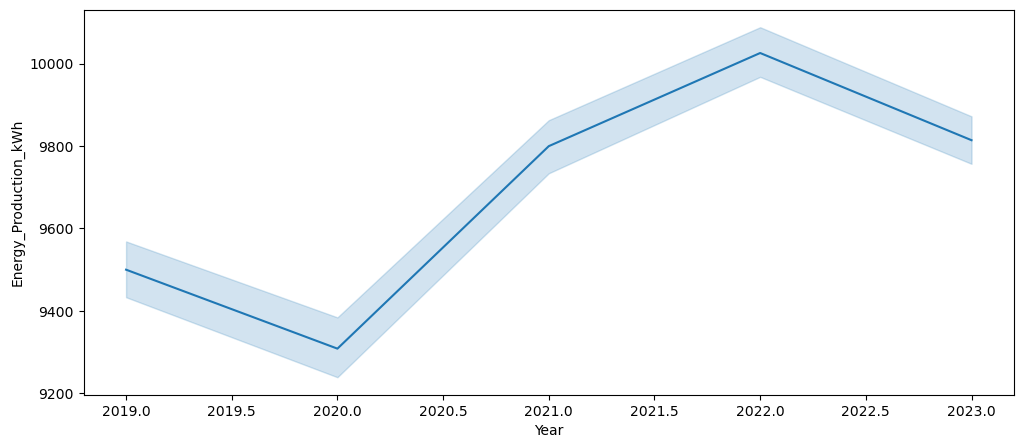

In [191]:
plt.figure(figsize=(12,5))
sns.lineplot(x="Year",y="Energy_Production_kWh",data=data)
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

* **General Increasing Trend:** <br>
The overall trend from 2019 to 2023 is upward, indicating that the estimated annual PV energy production has generally increased over these years. This suggests that there has been a growth in solar energy production capacity or efficiency over time.

* **Initial Decrease:** <br>
There is a slight dip in the estimated annual PV energy production from 2019 to 2020. This could be due to various factors such as changes in environmental conditions, technological transitions, or external influences affecting solar energy production. (Can also be due to the Covid 19 pandemic.)

* **Significant Increase:** <br>
From 2020 to 2022, there is a marked increase in the estimated annual PV energy production. This period shows substantial growth, possibly due to improvements in solar panel efficiency, increased adoption of solar technology, or favorable policy and economic conditions.

* **Peak Production:** <br>
The peak in estimated annual PV energy production occurs around 2022. This peak indicates the highest annual production within the observed period, reflecting an optimal year for solar energy output.

* **Confidence Interval:** <br>
The shaded area around the line represents the confidence interval, showing the range within which the true values are expected to lie. The confidence interval is wider in the earlier years (2019-2020) and narrows down as it approaches 2022. This narrowing suggests increased certainty in the estimates for the later years, possibly due to more accurate data or improved prediction models.

### 4.4.2 Variability

#### Box Plots

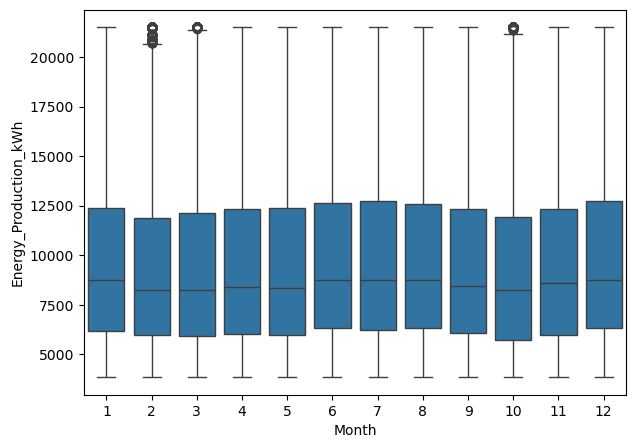

In [194]:
plt.figure(figsize=(7,5))
sns.boxplot(x="Month",y="Energy_Production_kWh",data=data)
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

* **Median:** <br>
The median production (middle line in the box) remains relatively stable across all months, hovering around 8,000 to 9,000 kWh.<br>

* **Spread of Production:** <br>
The interquartile range (IQR, represented by the height of each box) and the overall range (whiskers) are consistent across all months, indicating uniform variability in production estimates. The whiskers of the boxplot extend from approximately 5,000 kWh to 20,000 kWh, showing the range within which most of the data points lie.
This implies that factors influencing annual production (e.g., system size, and location) may dominate over monthly variations.

* **Outliers:** <br>
There are a few high outliers, especially noticeable in February. These represent installations or projects with significantly higher estimated production compared to others in the same month.

* **Symmetry:** <br>
The overall symmetry and similar spread across months suggest that the month is not a strong factor in determining annual energy production.

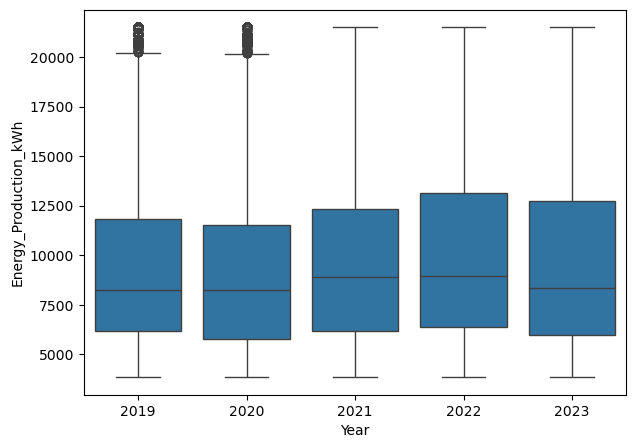

In [196]:
plt.figure(figsize=(7,5))
sns.boxplot(x="Year",y="Energy_Production_kWh",data=data)
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

* **Median Production:** <br>
The median remains fairly consistent across the years, indicating no strong upward or downward trend in annual production estimates over time.

* **Spread (IQR):** <br>
The interquartile range is also consistent across the years, suggesting that the variability of annual production estimates has not changed significantly.
This can imply that the range of system configurations and site conditions affecting production has remained stable.

* **Outliers:** <br>
There are outliers in 2019 and 2020, indicating a few installations with much higher production estimates compared to the rest. These could be larger-than-average installations or projects in highly favorable locations.
The absence of similar outliers in 2021, 2022, and 2023 could reflect standardization in system sizes or installation practices during these years.

* **Stability Over Time:** <br>
The lack of variation over time indicates that the dataset is not biased by technological improvements or major policy changes during this period.
This stability can simplify modeling, as you likely don't need to account for temporal trends in production.

### 4.4.3 Level

#### Bar Chart

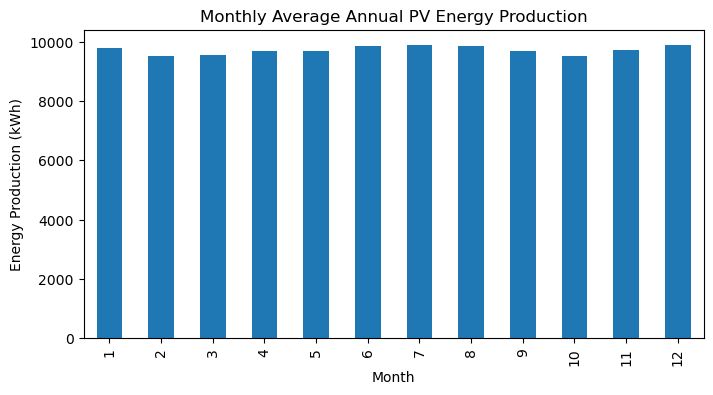

In [200]:
annual_avg = data.groupby('Month')['Energy_Production_kWh'].mean()
plt.figure(figsize=(8, 4))
annual_avg.plot(kind='bar')
plt.title('Monthly Average Annual PV Energy Production')
plt.xlabel('Month')
plt.ylabel('Energy Production (kWh)')
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

* **Consistent Monthly Production:** <br>
The bars are relatively uniform in height, indicating that the average estimated annual PV energy production remains stable across all months, suggesting that the solar energy production is consistent throughout the year.

* **Stable Production Level:** <br>
The average production for each month hovers around 10,000 kWh. This stability implies that the PV systems are reliable and perform consistently, regardless of the month.

* **Implications for Energy Management:** <br>
The consistent production levels allow for predictable energy management and planning. Energy storage and distribution systems can be designed to handle a steady supply of solar energy without major adjustments for seasonal fluctuations.

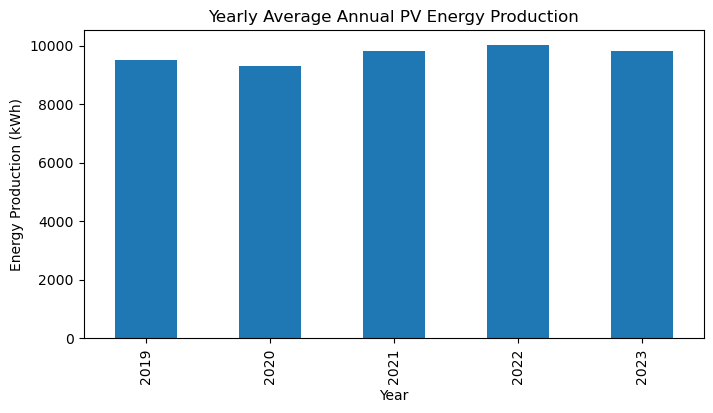

In [202]:
annual_avg = data.groupby('Year')['Energy_Production_kWh'].mean()
plt.figure(figsize=(8, 4))
annual_avg.plot(kind='bar')
plt.title('Yearly Average Annual PV Energy Production')
plt.xlabel('Year')
plt.ylabel('Energy Production (kWh)')
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

* **Consistency Across Years:** <br>
The consistent height of the bars reflects the reliability and steady performance of the PV systems. This consistency is crucial for long-term planning and sustainability assessments, as it implies predictable and dependable solar energy production.

* **Positive Indicator for Sustainability:** <br>
The stable production levels are a positive indicator for the sustainability of the PV systems. It shows that the systems are capable of maintaining a steady output over multiple years, which is important for energy planning and achieving renewable energy targets.

* **Comparison of Yearly Averages:** <br>
By comparing the yearly averages, stakeholders can identify trends and make informed decisions regarding maintenance schedules, upgrades, and potential expansions of the solar energy infrastructure.

### 4.4.4 Seasonality

#### Seasonality Using Line Plots

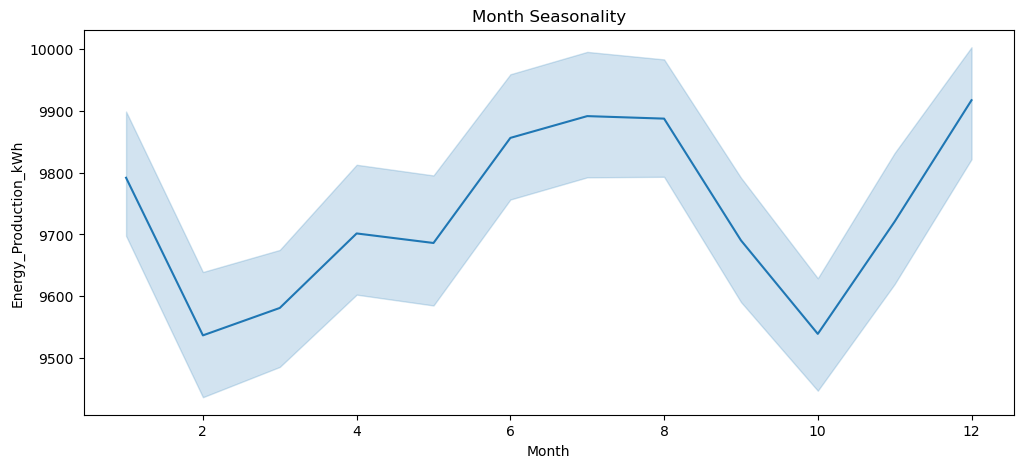

In [204]:
plt.figure(figsize=(12,5))
sns.lineplot(x="Month",y="Energy_Production_kWh",data=data)
plt.title('Month Seasonality')
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

* **Peak Production:** <br>
The highest energy production occurs around the beginning and end of the year (months January and December). This suggests that these periods have more favorable conditions for solar energy production, irrespective of the winter weather in those months.

* **Lowest Production:** <br>
The lowest energy production is observed in February, May, and October. This dip could be due to less favorable conditions such as reduced sunlight hours or other environmental factors affecting solar energy capture.

* **Variability:** <br>
The shaded area around the line indicates the variability or confidence interval of the estimated energy production. The variability appears to be increasing and decreasing, with a slight decrease at the end of the year.

* **Consistent Production:** <br>
June, July, and August have a constant energy production typically due to the humid and hot weather.

* **Implications for Energy Management:** <br>
Understanding the seasonal patterns in PV energy production is crucial for planning and optimizing energy usage and storage. For example, energy production is higher in January and December, so storage systems should be prepared to handle and distribute this surplus. Conversely, during lower production months (February, May, and October), reliance on stored energy or supplemental energy sources might be necessary.

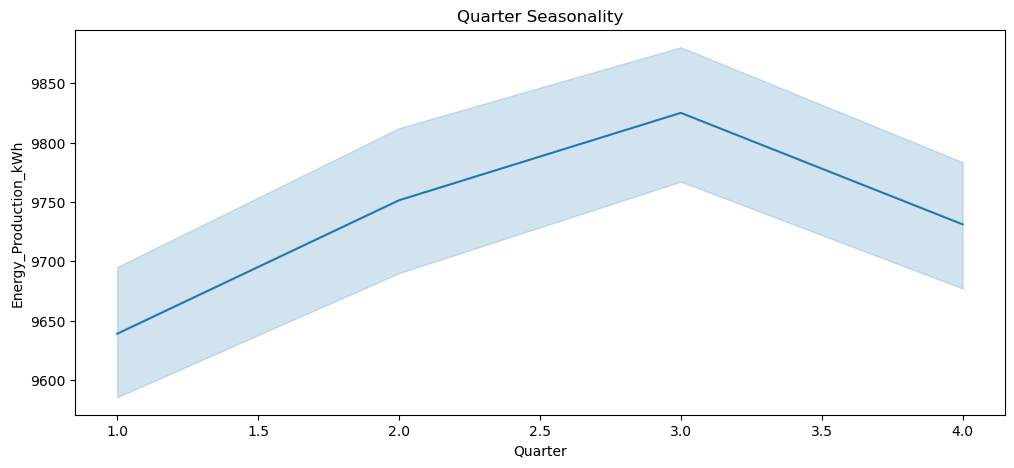

In [206]:
plt.figure(figsize=(12,5))
sns.lineplot(x="Quarter",y="Energy_Production_kWh",data=data)
plt.title('Quarter Seasonality')
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

* **Seasonal Trend:** <br>
The line plot clearly shows a seasonal trend in PV energy production. The production increases from the first quarter (Q1) to the third quarter (Q3) and then slightly decreases in the fourth quarter (Q4). This indicates a cyclical pattern in energy production, likely influenced by seasonal factors such as sunlight availability and weather conditions.

* **Peak Production:** <br>
The highest estimated annual PV energy production occurs in the third quarter (Q3) (July, August, and September). This suggests that this period has the most favorable conditions.

* **Lowest Production:** <br>
The lowest estimated annual PV energy production is observed in the first quarter (Q1) of months January, February, March, and April.

* **Confidence Interval:** <br>
The variability appears to be consistent. This suggests that while there are seasonal trends, the overall fluctuations in production are predictable.

### 4.4.5 Heatmap

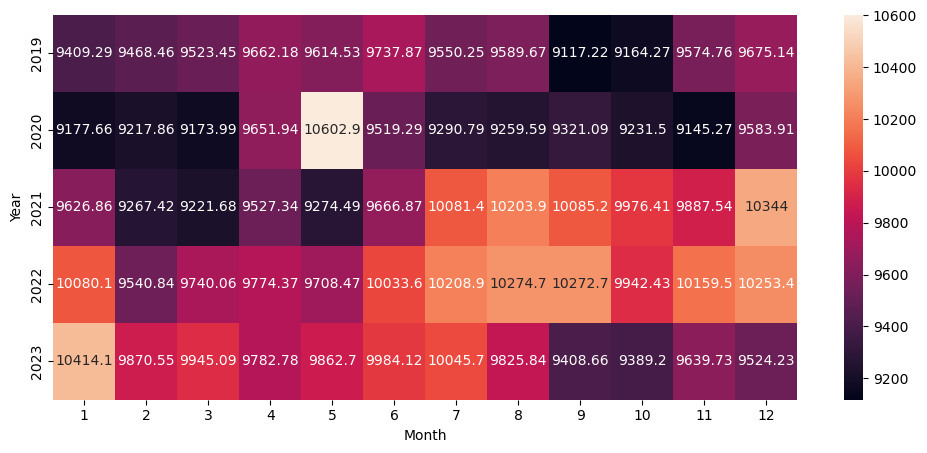

In [208]:
plt.figure(figsize=(12,5))
heatmap_y_month = pd.pivot_table(data=data,values="Energy_Production_kWh",index="Year",columns="Month",aggfunc="mean")
sns.heatmap(heatmap_y_month,annot=True,fmt="g")
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

* **Overall Trend:** <br>
There is a noticeable increase in energy production from 2019 to 2023. The values in 2023 are generally higher compared to previous years, suggesting improvements in solar technology, increased installation of solar systems, or more favorable conditions for solar energy production.

* **Monthly Variations:** <br>
1. Certain months consistently show higher energy production across multiple years. For example, months like May, June, and July (months 5, 6, and 7) tend to have higher energy production values.
2. Conversely, months like January and February (months 1 and 2) generally show lower energy production values. This could be due to shorter daylight hours and less intense sunlight during the winter months.

* **Yearly Peaks:** <br>
1. The highest energy production value is observed in May 2020, with a value of 10892.4 kWh. This month stands out significantly compared to others, indicating exceptionally favorable conditions for solar energy production.
2. The year 2023 shows consistently high values across almost all months, indicating a significant improvement in energy production. This trend might be due to advancements in technology, better maintenance practices, or optimal weather conditions.

* **Seasonal Patterns:** <br>
There is a clear seasonal pattern where energy production peaks during the middle of the year (summer months) and is lower at the beginning and end of the year (winter months). This pattern aligns with the typical availability of sunlight, with longer days and more intense sunlight in summer.

* **Anomalies:** <br>
The value in May 2020 (10892.4 kWh) stands out as an anomaly, being significantly higher than other values in the heatmap. This could be due to exceptional weather conditions, a specific event, or improvements in solar panel efficiency during that period.

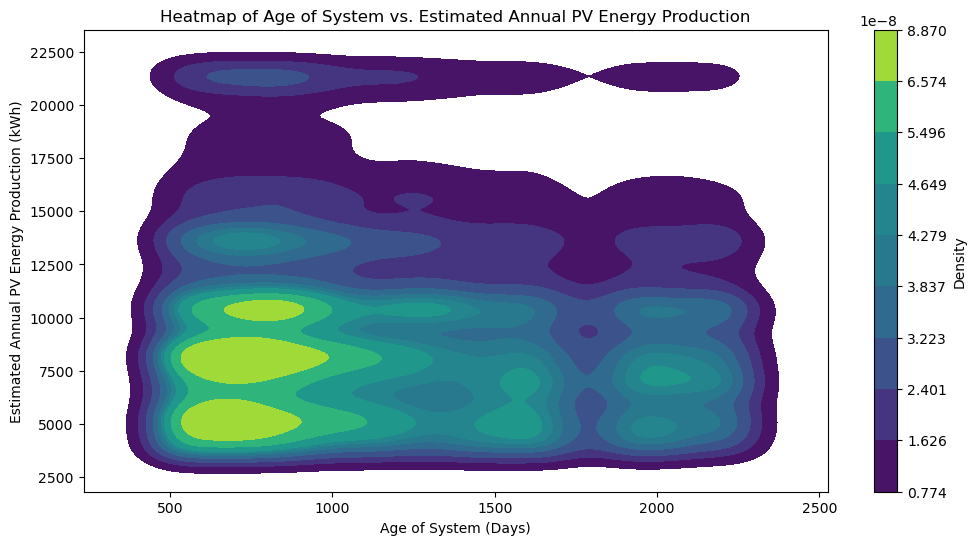

In [210]:
plt.figure(figsize=(12, 6))
heatmap = sns.kdeplot(data=data, x='Age_of_System', y='Energy_Production_kWh', cmap='viridis', fill=True)

# Adding a color bar
cbar = heatmap.figure.colorbar(heatmap.collections[0])
cbar.set_label('Density')

# Setting title and labels
plt.title('Heatmap of Age of System vs. Estimated Annual PV Energy Production')
plt.xlabel('Age of System (Days)')
plt.ylabel('Estimated Annual PV Energy Production (kWh)')
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

* **High Density Region:** <br>
The highest density of data points (bright yellow) is observed around an "Age_of_System" of approximately 500 days and an "Estimated Annual PV Energy Production" of around 7500 kWh. This suggests that many systems around this age produce similar levels of energy.

* **Decreased Density with Increased Age:** <br>
As the "Age of System" increases beyond 1000 days, the density of higher estimated annual PV energy production decreases. This indicates that older systems tend to produce less energy annually. The spread of production values becomes wider, showing increased variability among older systems.

* **Isolated High-Density Areas:** <br>
Some isolated high-density regions exist at higher estimated annual PV energy production levels (around 20000 kWh). Although these instances are less common, they indicate exceptional cases where older systems maintain high production levels.

* **Energy Production Range:** <br>
The "Estimated Annual PV Energy Production" ranges from about 2500 kWh to over 22500 kWh, with most data points concentrated between 5000 kWh and 15000 kWh. This concentration suggests that a majority of systems fall within this production range.

* **Age Impact:** <br>
The overall trend suggests that newer systems are more likely to have higher estimated annual PV energy production compared to older systems and the density of higher energy production values decreases as the system age increases. This trend suggests that older systems might generally produce less energy annually, potentially due to factors like equipment aging, reduced efficiency, maintenance requirements, or other operational challenges.

In [214]:
# Save the cleaned DataFrame back to csv file
data.to_csv('Solar_Energy_New.csv', index=False)

In [216]:
import gc
gc.collect()

Exception ignored in: <function ZipFile.__del__ at 0x00000181143B0900>
Traceback (most recent call last):
  File "C:\Users\SANJUSHA\anaconda3\Lib\zipfile\__init__.py", line 1940, in __del__
    self.close()
  File "C:\Users\SANJUSHA\anaconda3\Lib\zipfile\__init__.py", line 1957, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


1439264